## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from scipy import stats
import random
import seaborn
import warnings

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (15.0, 7.0)

%matplotlib inline

## Read Data

In [2]:
df = pd.read_csv('q_data_x.csv')
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


## Result of Linear Regression

In [3]:
# まず、線形回帰を行い、CMを見たかどうか（cm_dummyが0か1か）によって、
# ゲームプレイ時間が有意に異なっているかを調べる。

x = df['cm_dummy'] # 説明変数
x = sm.add_constant(x) # 全要素が1の列を説明変数の先頭に追加
y = df['gamesecond'] # 目的変数

# モデル作成・予測
LinearRegModel = sm.OLS(y, x)
results = LinearRegModel.fit()
 
# 結果
# 傾きが-629.64なので、CMを見なかった人に比べてCMを見た人の方が、
# ゲームプレイ時間が630秒短いと解釈できる。
# ただし、標準誤差が大きくp値も0.08であるため、有意な差があるとは言えない。
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,3107.7065,234.851,13.233,0.000,2647.352,3568.061
cm_dummy,-629.6406,364.823,-1.726,0.084,-1344.767,85.485


## Propensity Score

In [4]:
# 傾向スコアを計算
# ロジスティクス回帰で被説明変数にCMを観たかどうかを置く（cm_dummyをtargetとし、他の変数で予測する）
# それぞれの人がCMを見るかどうかの確率を算出
LogRegModel = LogisticRegression()
LogRegModel.fit(df.drop('cm_dummy', axis = 1), df['cm_dummy'])

results = LogRegModel.predict_proba(df.drop('cm_dummy', axis = 1))[: ,1]
df['propensity_score'] = results

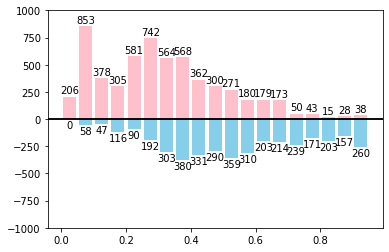

In [5]:
# 結果を可視化
# 傾向スコアの分布が、CMを見た/見ていないで異なっていることがわかる。
propensity0 = df[df['cm_dummy'] == 0]['propensity_score']
propensity1 = df[df['cm_dummy'] == 1]['propensity_score']

bins = np.arange(0, 1, 0.05)
top0, _ = np.histogram(propensity0, bins = bins)
top1, _ = np.histogram(propensity1, bins = bins)

plt.ylim(-1000,1000)
plt.axhline(0, c = 'black')
plt.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor = 'pink')
plt.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor = 'skyblue')
plt.axhline(0, c = 'black')

for x, y in zip(bins, top0):
    plt.text(x + 0.025, y + 10, str(y), ha = 'center', va = 'bottom')

for x, y in zip(bins, top1):
    plt.text(x + 0.025, -y - 10, str(y), ha = 'center', va = 'top')

In [6]:
# 傾向スコアの分布が、CMを見た/見ていないで異なっていることから、
# 傾向スコアが近い人をマッチングさせ、分布を均等にする。

#マッチングの範囲を指定
inter = np.arange(0, 1, 0.005)
df_match = pd.DataFrame()

#一つ目の条件で、CM0とCM1のどちらか一方が0人の場合を除外する。
for i in inter:
    match0 = df[(df['cm_dummy'] == 0)&(i - 0.005 < df['propensity_score'])&(df['propensity_score'] < i)]
    match1 = df[(df['cm_dummy'] == 1)&(i - 0.005 < df['propensity_score'])&(df['propensity_score'] < i)]
    
   #二つ目の条件で人数が少ない方に合わせてランダムにマッチングする 
    if len(match0) > 0 and len(match1) > 0:
        if len(match0) <= len(match1):
            match1= match1.sample(len(match0))
            df_match = pd.concat([df_match, match0, match1])
        else :
            match0 = match0.sample(len(match1))
            df_match = pd.concat([df_match, match0, match1])

In [7]:
df_match.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount,propensity_score
3402,0,0,0,0,0,1,34.5,1,0,0,...,0,0,0,0,1,0,72.821161,0,0,0.063254
2372,0,0,0,0,0,1,34.5,0,1,0,...,1,0,0,0,0,0,4169.191919,0,0,0.064446
1709,0,0,0,0,0,1,60.0,1,1,1,...,0,0,0,0,0,1,4531.778590,0,0,0.063943
2963,0,0,0,0,0,1,24.5,1,0,1,...,0,0,0,1,0,0,2777.595333,0,0,0.064503
2417,0,0,0,0,0,1,24.5,0,0,1,...,1,0,0,0,0,0,4981.846391,0,0,0.063766


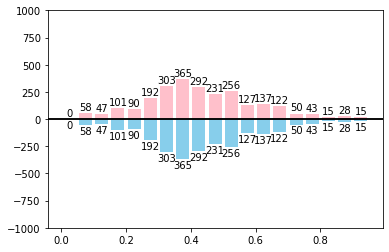

In [8]:
#可視化
# 傾向スコアの分布が、CMを見た/見ていないである程度同じになった。
propensity0 = df_match[df_match['cm_dummy'] == 0]['propensity_score']
propensity1 = df_match[df_match['cm_dummy'] == 1]['propensity_score']

bins = np.arange(0, 1, 0.05)
top0, _ = np.histogram(propensity0, bins = bins)
top1, _ = np.histogram(propensity1, bins = bins)

plt.ylim(-1000,1000)
plt.axhline(0, c = 'black')
plt.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor = 'pink')
plt.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor = 'skyblue')
plt.axhline(0, c = 'black')

for x, y in zip(bins, top0):
    plt.text(x + 0.025, y + 10, str(y), ha = 'center', va = 'bottom')

for x, y in zip(bins, top1):
    plt.text(x + 0.025, -y - 10, str(y), ha = 'center', va = 'top')

## Linear Regression Again

In [9]:
x = df_match['cm_dummy'] # 説明変数
x = sm.add_constant(x) # 全要素が1の列を説明変数の先頭に追加
y = df_match['gamesecond'] # 目的変数

# モデル作成・予測
LinearRegModel = sm.OLS(y, x)
results = LinearRegModel.fit()
 
# 結果
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,3434.8656,342.554,10.027,0.000,2763.309,4106.422
cm_dummy,-586.9623,484.445,-1.212,0.226,-1536.687,362.763


In [10]:
# 最初と同様に、CMを見ていない方がゲームプレイ時間が短いという結果になった。
# 考えられる原因1：他に交絡因子があった。
# 考えられる原因2：サンプル数が減ったため、それ自体がバイアスになってしまった。